# System preparation

## Import libraries

In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Data 
import numpy as np
import pandas as pd

#Regular expressions
import re as re

# Utilities
from time import time

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Classification
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score , roc_auc_score

from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score

# Classification algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier


# Others
import warnings
from functools import reduce
from pathlib import Path
import os


In [2]:
# Configurations.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

# Data preparation

### Load data



Read the csv with the feature engineering applied before to the raw data.

In [3]:
compressors_all_data = pd.read_csv("data/compressors_all_data_best_features_2days.csv", error_bad_lines=False, index_col=0)

In [4]:
#Make sure the datetime format is correct
compressors_all_data["datetime"] = pd.to_datetime(compressors_all_data["datetime"], format="%Y-%m-%d %H:%M:%S")

In [5]:
compressors_all_data.head()

,compressorID,datetime,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,...,s-8760,c-8760,comp1_fail,comp2_fail,comp3_fail,comp4_fail,rul_comp1,rul_comp2,rul_comp3,rul_comp4
0,1,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502,NaN,NaN,NaN,...,0.000000,1.000000,0.0,0.0,0.0,0.0,63.875,108.875,NaN,3.875
1,1,2015-01-01 12:00:00,2,164.192565,403.949857,105.687417,34.255891,NaN,NaN,NaN,...,0.002152,0.999998,0.0,0.0,0.0,0.0,63.750,108.750,NaN,3.750
2,1,2015-01-01 15:00:00,3,168.134445,435.781707,107.793709,41.239405,NaN,NaN,NaN,...,0.004304,0.999991,0.0,0.0,0.0,0.0,63.625,108.625,NaN,3.625
3,1,2015-01-01 18:00:00,4,165.514453,430.472823,101.703289,40.373739,NaN,NaN,NaN,...,0.006455,0.999979,0.0,0.0,0.0,0.0,63.500,108.500,NaN,3.500
4,1,2015-01-01 21:00:00,5,168.809347,437.111120,90.911060,41.738542,NaN,NaN,NaN,...,0.008607,0.999963,0.0,0.0,0.0,0.0,63.375,108.375,NaN,3.375


Create lists with the names of the columns for different data:
- Sensors: telemetry information
- Errors: compressor errors and counts
- Maintenance: time since last maintenance
- Model
- Compressor information: Age
- Failures: failures in the different components

## Feature selection

Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

In [6]:
cols_failures_dum = [col for col in compressors_all_data.columns if 'fail' in col]
cols_rul = [col for col in compressors_all_data.columns if 'rul' in col]

In [7]:
predictors = list(compressors_all_data.columns)
predictors = [ele for ele in predictors if ele not in (cols_rul + cols_failures_dum + ['datetime']) ]

In [8]:
target = cols_failures_dum 

In [9]:
X = compressors_all_data[(predictors+target)+ ['datetime']].dropna()
y = compressors_all_data[(predictors+target)+ ['datetime']].dropna()

In [10]:
X = X[predictors+ ['datetime']]
y= y[target+ ['datetime']]

## Model split: Training, Validation and Testing

When working with time series as in this thesis, partitioning in training, validation, and testing must be done carefully to avoid overestimating the performance of the models. 

Predictive models do not have advanced knowledge of future time trends - in practice, such trends are likely to exist and have an adverse impact on model performance. To get an accurate assessment of the performance of a predictive model, it is recommended to perform training on older records and validation / testing using the newer records.

For both reasons, a time-dependent splitting strategy is an excellent choice for predictive maintenance models. The division is done by choosing a point in time according to the desired size of the training and test sets: all the records before the time point are used to train the model, and all the remaining records are used for testing.

In [11]:
# We establish the times corresponding to the records that will be used for training and tests.
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [12]:
# We make the partition of separate dates.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [13]:
# Typically 20-30% of the data is used.
X_train = X.loc[X["datetime"] < last_train_date]
y_train = y.loc[y["datetime"] < last_train_date]

X_test = X.loc[X["datetime"] > first_test_date]
y_test = y.loc[y["datetime"] > first_test_date]

print(f"{X_train.shape[0]} registers for trainning")
print(f"{X_test.shape[0]} registers for testing")
print(f"{X_test.shape[0] / X_train.shape[0] * 100:0.1f}% of the total data is used for testing")

216700 registers for trainning
73900 registers for testing
34.1% of the total data is used for testing


Check how many failures we have in the train and test

In [14]:
fails_train = y_train[y_train["comp1_fail"] != 0].shape[0]
no_fails_train = y_train[y_train["comp1_fail"] == 0].shape[0]
fails_test = y_test[y_test["comp1_fail"] != 0].shape[0]
no_fails_test = y_test[y_test["comp1_fail"] == 0].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% of the total cases are failures in the train dataset")
print(f"{fails_test / no_fails_test * 100:0.1f}% of the total cases are failures in the test dataset")

1.1% of the total cases are failures in the train dataset
0.9% of the total cases are failures in the test dataset


We see it's crearly an unbalanced problem. For class unbalance problems Get more data. Minor sample of the majority class. SMOTE (Synthetic Minority Over-sampling Technique). Assign weights to minority class.

## Drop Datetime

In [15]:
X.drop('datetime', axis=1,inplace=True)
y.drop('datetime', axis=1,inplace=True)

X_train.drop('datetime',axis=1,inplace=True)
y_train.drop('datetime',axis=1,inplace=True)

X_test.drop('datetime',axis=1,inplace=True)
y_test.drop('datetime',axis=1,inplace=True)

# LightGBM Hyperparameter Tuning

From the comparison in the previous section, one of the models with best performance is the LightGBM. We will tune the hyperparameters of the model to boost its performance.

## MVP LightGBM

In [16]:
# build the lightgbm model
import lightgbm as lgb

In [17]:
clf = lgb.LGBMClassifier()
for comp in y:
  clf.fit(X_train, y_train[comp])
  # predict the results
  y_pred=clf.predict(X_test)
  # view accuracy
  from sklearn.metrics import accuracy_score
  accuracy=accuracy_score(y_pred, y_test[comp])
  print(f'For {comp}')
  print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test[comp], y_pred)))

For comp1_fail
LightGBM Model accuracy score: 0.9937
For comp2_fail
LightGBM Model accuracy score: 0.9940
For comp3_fail
LightGBM Model accuracy score: 0.9973
For comp4_fail
LightGBM Model accuracy score: 0.9969


In [18]:
import lightgbm 
from lightgbm import *

In [19]:
lgb = LGBMClassifier()

In [20]:
# Loop for the different components

for comp in y_train.columns:
  lgb.fit(X_train, y_train[comp])
  y_pred = lgb.predict(X_test)
  y_pred_prob = lgb.predict_proba(X_test)
  
  # view confusion-matrix
  # Print the Confusion Matrix and slice it into four pieces

  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_test[comp], y_pred)
  print(f'Evaluation of {comp}')
  print('Confusion matrix\n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])
  print()
  auc = roc_auc_score(y_test[comp], y_pred)
  print(f'AUC = {auc}')
  print()


Evaluation of comp1_fail
Confusion matrix

 [[73077   128]
 [  337   358]]

True Positives(TP) =  73077

True Negatives(TN) =  358

False Positives(FP) =  128

False Negatives(FN) =  337

AUC = 0.7566796996116651

Evaluation of comp2_fail
Confusion matrix

 [[72494   247]
 [  193   966]]

True Positives(TP) =  72494

True Negatives(TN) =  966

False Positives(FP) =  247

False Negatives(FN) =  193

AUC = 0.9150407631914094

Evaluation of comp3_fail
Confusion matrix

 [[73293   136]
 [   66   405]]

True Positives(TP) =  73293

True Negatives(TN) =  405

False Positives(FP) =  136

False Negatives(FN) =  66

AUC = 0.9290102410986201

Evaluation of comp4_fail
Confusion matrix

 [[73074   157]
 [   74   595]]

True Positives(TP) =  73074

True Negatives(TN) =  595

False Positives(FP) =  157

False Negatives(FN) =  74

AUC = 0.9436216220927455



## Randomized search

Let’s try to optimise our predictive model using these three core parameters:

- Objective: Binary classification in this case.
- num_boost_round: Number of boosting iterations, typically 100 and above.
- learning_rate: The impact of each tree on the final outcome. The learning parameter controls the magnitude of this change in the estimates.
- num_leaves: number of leaves in the entire tree, the LightGBM default: 31.

In [27]:
params={
         'learning_rate': np.arange(0.01, 0.15, 0.03),
         'num_leaves': np.arange(10, 100, 30),
         'max_depth': np.arange(3, 10, 2),
         'scale_pos_weight': [1, 20, 50, 100, 500]}

In [28]:
lgbmc_classifier = LGBMClassifier(objective = 'binary',n_jobs=-1)

In [29]:
stf_kf=StratifiedKFold(n_splits=5)

In [30]:
rs_cv_classifier=RandomizedSearchCV(lgbmc_classifier,
                                    param_distributions=params,
                                    cv=stf_kf,
                                    scoring='roc_auc',
                                    n_jobs=-1)

In [31]:
for comp in y_train:
  # execute search
  start_time = time()

  rs_cv_classifier.fit(X_train,y_train[comp])

  rs_cv_time = time() - start_time

  y_pred=rs_cv_classifier.predict(X_test)


  print(f"Best Parameter for {comp}: \n",rs_cv_classifier.best_params_)
  print(f"Total time {rs_cv_time}")

  cm = confusion_matrix(y_test[comp], y_pred)
  print('Confusion matrix\n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])
  print()
  auc = roc_auc_score(y_test[comp], y_pred)
  print(f'AUC = {auc}')
  print()

Best Parameter for comp1_fail: 
 {'scale_pos_weight': 100, 'num_leaves': 70, 'max_depth': 5, 'learning_rate': 0.04}
Total time 46.37879991531372
Confusion matrix

 [[72412   793]
 [   91   604]]

True Positives(TP) =  72412

True Negatives(TN) =  604

False Positives(FP) =  793

False Negatives(FN) =  91

AUC = 0.9291160773996745

Best Parameter for comp2_fail: 
 {'scale_pos_weight': 50, 'num_leaves': 10, 'max_depth': 5, 'learning_rate': 0.04}
Total time 46.25231313705444
Confusion matrix

 [[72042   699]
 [   24  1135]]

True Positives(TP) =  72042

True Negatives(TN) =  1135

False Positives(FP) =  699

False Negatives(FN) =  24

AUC = 0.9848415286549953

Best Parameter for comp3_fail: 
 {'scale_pos_weight': 500, 'num_leaves': 10, 'max_depth': 7, 'learning_rate': 0.06999999999999999}
Total time 41.40207290649414
Confusion matrix

 [[73314   115]
 [   53   418]]

True Positives(TP) =  73314

True Negatives(TN) =  418

False Positives(FP) =  115

False Negatives(FN) =  53

AUC = 0.9429

[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] Unknown pa

## Best hyperparameters

We collect in a table the outputs from the Random Search in the previous step

HyperParameter | Component 1 | Component 2 | Component 3 | Component 4  
--- | --- | --- | --- | ---
learning_rate | 0.04 | 0.04 | 0.0699999 | 0.069999
num_leaves | 70 | 10 | 10 | 70
max_depth | 5 | 5 | 7 | 5
scale_pos_weight | 100 | 50 | 500 | 1


In [38]:
lgb_comp1_fail = LGBMClassifier(learning_rate=0.04,
                                num_leaves=70,
                                max_depth = 5,
                                scale_pos_weight = 100)

In [39]:
lgb_comp2_fail = LGBMClassifier(learning_rate=0.04,
                                num_leaves=10,
                                max_depth = 5,
                                scale_pos_weight = 50)

In [40]:
lgb_comp3_fail = LGBMClassifier(learning_rate=0.069999999,
                                num_leaves=10,
                                max_depth = 7,
                                scale_pos_weight = 500)

In [41]:
lgb_comp4_fail = LGBMClassifier(learning_rate=0.0699999,
                                num_leaves=70,
                                max_depth = 5,
                                scale_pos_weight = 1)

#### Report

We create a report with the classification metrics for the models built in the previous step.

- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

- ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

Evaluation of comp1_fail
Confusion matrix

 [[72412   793]
 [   91   604]]

True Positives(TP) =  72412

True Negatives(TN) =  604

False Positives(FP) =  793

False Negatives(FN) =  91

AUC = 0.9291160773996745

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     73205
         1.0       0.43      0.87      0.58       695

    accuracy                           0.99     73900
   macro avg       0.72      0.93      0.79     73900
weighted avg       0.99      0.99      0.99     73900



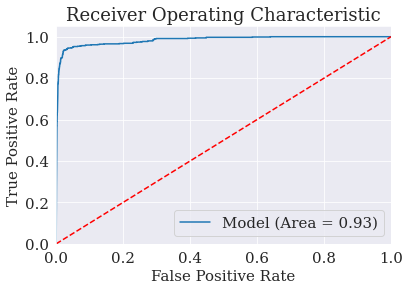

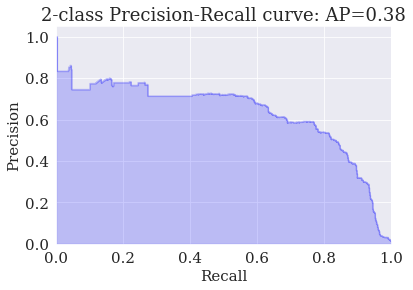


Evaluation of comp2_fail
Confusion matrix

 [[72042   699]
 [   24  1135]]

True Positives(TP) =  72042

True Negatives(TN) =  1135

False Positives(FP) =  699

False Negatives(FN) =  24

AUC = 0.9848415286549953

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     72741
         1.0       0.62      0.98      0.76      1159

    accuracy                           0.99     73900
   macro avg       0.81      0.98      0.88     73900
weighted avg       0.99      0.99      0.99     73900



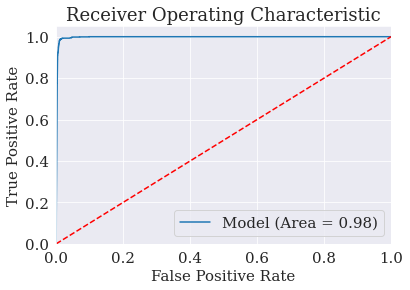

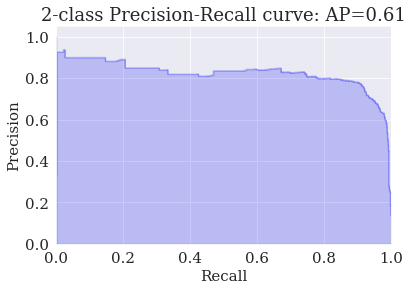


Evaluation of comp3_fail
Confusion matrix

 [[73314   115]
 [   53   418]]

True Positives(TP) =  73314

True Negatives(TN) =  418

False Positives(FP) =  115

False Negatives(FN) =  53

AUC = 0.9429536610014169

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     73429
         1.0       0.78      0.89      0.83       471

    accuracy                           1.00     73900
   macro avg       0.89      0.94      0.92     73900
weighted avg       1.00      1.00      1.00     73900



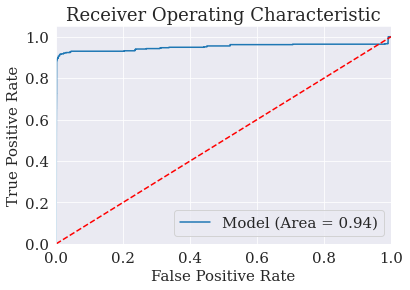

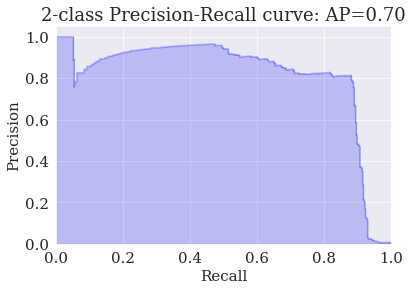


Evaluation of comp4_fail
Confusion matrix

 [[73099   132]
 [   60   609]]

True Positives(TP) =  73099

True Negatives(TN) =  609

False Positives(FP) =  132

False Negatives(FN) =  60

AUC = 0.9542556930085417

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     73231
         1.0       0.82      0.91      0.86       669

    accuracy                           1.00     73900
   macro avg       0.91      0.95      0.93     73900
weighted avg       1.00      1.00      1.00     73900



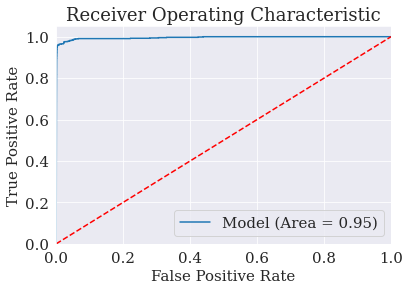

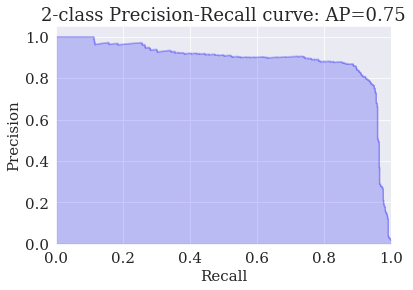

In [42]:
# Loop for the different components

for comp in y_train.columns:
  exec('lgb_temp = lgb_{}'.format(comp))
  lgb_temp.fit(X_train, y_train[comp])
  y_pred = lgb_temp.predict(X_test)
  y_pred_prob = lgb_temp.predict_proba(X_test)[:,1]
  
  
  # view confusion-matrix
  # Print the Confusion Matrix and slice it into four pieces

  cm = confusion_matrix(y_test[comp], y_pred)
  print(f'Evaluation of {comp}')
  print('Confusion matrix\n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])
  print()
  auc = roc_auc_score(y_test[comp], y_pred)
  print(f'AUC = {auc}')
  print()


  # Report
  print(classification_report(y_test[comp], y_pred))

  # Calculate area under the curve (logit_roc_auc)
  logit_roc_auc = roc_auc_score(y_test[comp], y_pred) 
  # Plot ROC
  fpr, tpr, thresholds = roc_curve(y_test[comp], y_pred_prob) 
  plt.figure()
  plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % logit_roc_auc) 
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.savefig(f'LightGBM_ROC_{comp}')
  plt.show()

  # Get average precision
  average_precision = average_precision_score(y_test[comp], y_pred)
  # Plot PR
  precision, recall, _ = precision_recall_curve(y_test[comp], y_pred_prob)
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(f'2-class Precision-Recall curve: AP={average_precision:.2f}')
  plt.savefig(f'LightGBM_PR_{comp}')
  plt.show()

  print()

# Save the best model

Let's define the hyperparameters of the model to be saved.
The whole dataset will be used to fit the model and enrich both from the training and testing data.


In [43]:
X = compressors_all_data[(predictors+target)].dropna()
y = compressors_all_data[(predictors+target)].dropna()

X = X[predictors]
y= y[target]

In [44]:
for comp in y_train.columns:
  exec('lgb_temp = lgb_{}'.format(comp))
  lgb_temp.fit(X, y[comp])
  lgb_temp.booster_.save_model(f"lgb_model_{comp}.model")